In [24]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

import pandas as pd
%matplotlib inline

Index(['RA', 'DEC', 'ID', 'Z', 'NZ'], dtype='object')


Text(0.5, 0, '$z$')

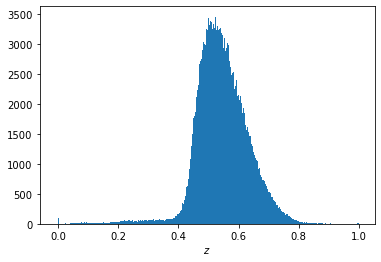

In [26]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

def read_nobs_pyfits(filename):
    with fits.open(filename, memmap=True) as hdul:
        data = (hdul[1].data)
        return np.shape(data)[0], hdul[1].columns.names

def read_test_pyfits(filename, colname):
    with fits.open(filename, memmap=True) as hdul:
        data = (hdul[1].data[colname])
        return data.copy()

def get_BOSS_data(gal):
    nObs, cols = read_nobs_pyfits(gal)
    colnames = [x for x in cols if x in ['ID', 'RA', 'DEC', 'Z', 'NZ', 'BOSS_SPECOBJ_ID',
                                         'BOSS_TARGET1', 'BOSS_TARGET2', 'EBOSS_TARGET0', 'ZOFFSET', 'TARGETOBJID',
                                         'OBJID', 'PLUG_RA', 'PLUG_DEC', 'Z']]
    ncols = len(colnames)
    myGalaxy = pd.DataFrame(data=np.zeros([nObs, ncols]), columns=colnames)
    for rowname in myGalaxy.columns:
        myGalaxy[rowname] = read_test_pyfits(gal, rowname).byteswap().newbyteorder()
    print(myGalaxy.columns)
    myGalaxy = myGalaxy.sort_values(by=['Z'])
    return myGalaxy



# Load the relevant entries of the catalog (we will be mostly concerned with RA, DEC, and redshift)
boss_catalog = get_BOSS_data(boss_catalog_path)


In [29]:
catalog_path = 'galaxy_DR12v5_CMASS_North.fits'  # use the actual fits file reading w astropy

boss_catalog_path = 'galaxy_DR12v5_CMASS_North.fits'

# Load the relevant entries of the catalog (we will be mostly concerned with RA, DEC, and redshift)
data = get_BOSS_data(boss_catalog_path)

data

# im trying to get the shit from dec, ra is working idfk why dec isnt 

Index(['RA', 'DEC', 'ID', 'Z', 'NZ'], dtype='object')


,RA,DEC,ID,Z,NZ
261519,122.745442,56.429233,1118,-0.011447,0.000000e+00
518946,148.722344,47.536602,36,-0.009278,0.000000e+00
161497,227.733313,33.839094,596,-0.007680,0.000000e+00
236230,260.933196,31.721466,468,-0.000668,0.000000e+00
246336,240.993446,33.791454,113,-0.000356,0.000000e+00
...,...,...,...,...,...
277736,237.752120,10.147784,629,1.000886,1.871761e-07
593579,211.376520,53.291920,78,1.002166,1.006226e-07
349585,206.707362,15.513130,179,1.002166,1.006226e-07
184815,130.842201,1.015843,555,1.002166,1.006226e-07


In [36]:
nside = 2048

print(data['RA'])



261519    122.745442
518946    148.722344
161497    227.733313
236230    260.933196
246336    240.993446
             ...    
277736    237.752120
593579    211.376520
349585    206.707362
184815    130.842201
244950    236.030861
Name: RA, Length: 618806, dtype: float64


/var/folders/kk/rnqql9614nlc_8x0td93qcf40000gn/T/ipykernel_72462/1107951859.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gal_hpmap = np.zeros(npix, dtype=np.float)


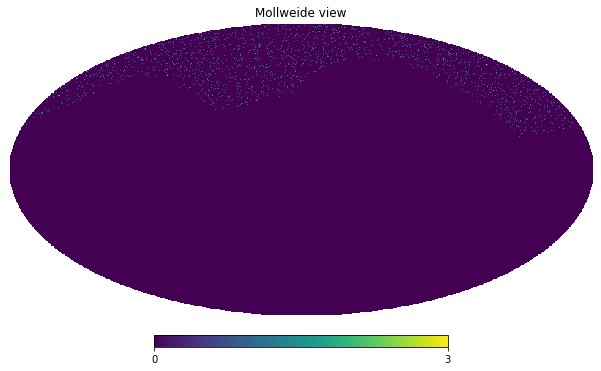

In [37]:
npix = hp.nside2npix(nside)
# Go from HEALPix coordinates to indices, implicitly converting to galactic coordinates
c_icrs = SkyCoord(ra=data['RA']*u.degree, dec=data['DEC']*u.degree, frame='icrs')
indices = hp.ang2pix(nside, c_icrs.galactic.l.value, c_icrs.galactic.b.value, lonlat=True)
# Initate the map and fill it with the values
gal_hpmap = np.zeros(npix, dtype=np.float)
# Assign sources to pixels
np.add.at(gal_hpmap, indices, 1)

hp.mollview(gal_hpmap)

AttributeError: 'numpy.ndarray' object has no attribute 'writeto'

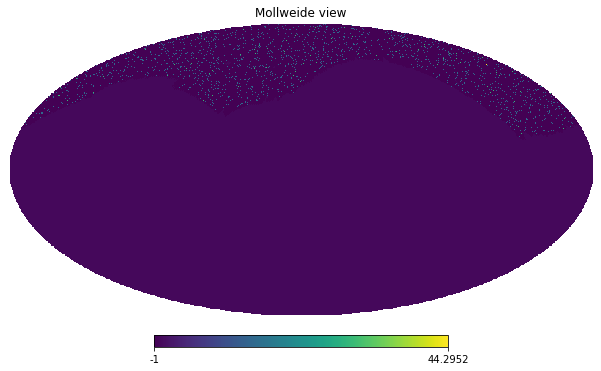

In [42]:
def get_dn_from_map(gal_hpmap):
    ''' Convert a galaxy number map obtained using get_map_from_catalog() to one of fractional
        overdensity. Return also the mask
    ''' 
    #Total number counts. Should convert to delta_n/n. Make a mask first!
    gal_downgraded = hp.ud_grade(gal_hpmap, 64)
    gal_mask = np.zeros(len(gal_downgraded))
    gal_mask[(gal_downgraded > 0)] = 1
    nside = hp.npix2nside(len(gal_hpmap))
    gal_mask = hp.ud_grade(gal_mask, nside) # bring it back to the original resolution
    
    # Convert to delta_n / n (fractional fluctuations: this is what we can predict from theory)
    mean_gal = np.sum(gal_hpmap * gal_mask) / np.sum(gal_mask)
    gal_masked_dn = (gal_hpmap * gal_mask) / mean_gal - 1.
    gal_masked_dn = gal_mask * gal_masked_dn
    return gal_masked_dn, gal_mask

gal_dn, gal_mask = get_dn_from_map(gal_hpmap)

hp.mollview(gal_dn)

